# Predict Boston House Price: A Deep Learning Approach with Keras (Subclassing Modeling)
- **Date**: 2/17/2023.
- **Author**: [Minh T. Nguyen](https://www.kaggle.com/minhbtnguyen).
- **Dataset**: [Boston House Prices](https://www.kaggle.com/datasets/fedesoriano/the-boston-houseprice-data).
- **Task**: Regression.
- **Framework**: Keras, Sklearn.

**Note**: *I use Kaggle to learn from others and practice my skills so any comment or suggestion is welcome!* 

**Related Notebooks:**
- [Sequential Keras Modeling | Regression | Boston HP](https://www.kaggle.com/code/minhbtnguyen/sequential-keras-modeling-regression-boston-hp).
- [Functional Keras Modeling | Regression | Boston HP](https://www.kaggle.com/code/minhbtnguyen/functional-keras-modeling-regression-boston-hp).

![](https://images.unsplash.com/photo-1572128023846-8cf5791a1299?ixlib=rb-4.0.3&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=1032&q=80)

In [1]:
# import libraries
import numpy as np
import pandas as pd
import os 
import matplotlib.pyplot as plt
import copy

# import tensorflow
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
# set random seed for same results when reproducing the notebook
np.random.seed(0)

# 1. Import Dataset

In [3]:
# connect with Kaggle directory
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/the-boston-houseprice-data/boston.csv


In [4]:
# import dataset
df = pd.read_csv("/kaggle/input/the-boston-houseprice-data/boston.csv")
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


In [5]:
# check the shape of the dataset
print(df.shape)

(506, 14)


In [6]:
# check datatypes of each feature
df.dtypes

CRIM       float64
ZN         float64
INDUS      float64
CHAS         int64
NOX        float64
RM         float64
AGE        float64
DIS        float64
RAD          int64
TAX        float64
PTRATIO    float64
B          float64
LSTAT      float64
MEDV       float64
dtype: object

**Note**: From the metadata, we learn that each column has different meaning:
- **CRIM**: per capita crime rate by town.
- **ZN**: proportion of residential land zoned for lots over 25,000 sq.ft.
- **INDUS**: proportion of non-retail business acres per town.
- **CHAS**: Charles River dummy variable (1 if tract bounds river; 0 otherwise).
- **NOX**: nitric oxides concentration (parts per 10 million) [parts/10M].
- **RM**: average number of rooms per dwelling.
- **AGE**: proportion of owner-occupied units built prior to 1940.
- **DIS**: weighted distances to five Boston employment centres.
- **RAD**: index of accessibility to radial highways.
- **TAX**: full-value property-tax rate per `$10,000 [$/10k]`.
- **PTRATIO**: pupil-teacher ratio by town.
- **B**: The result of the equation B=1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town.
- **LSTAT**: % lower status of the population.
- **MEDV**: Median value of owner-occupied homes in `$1000's [k$]`.

# 2. Data Visualization & Analysis
**Note**: From the table, we can see that the data has various ranges. Thus, we need to normalize all features into the same range so that the visualization of features won't be compressed.


**Note**: Shape of the normal distribution (Gaussian distribution).

![](https://cdn.scribbr.com/wp-content/uploads/2020/10/standard-normal-distribution-1024x633.png)

**Note**: Let's plot the features (columns) of the dataset and see how they shape compared to the Gaussian distribution.

In [7]:
# normalize the dataset prior to plot
df_plot = df.copy() # made a copy of the dataframe here as we have different normalization process in the later step
mean = df_plot.mean(axis=0)
df_plot -= mean
std = df_plot.std(axis=0)
df_plot /= std

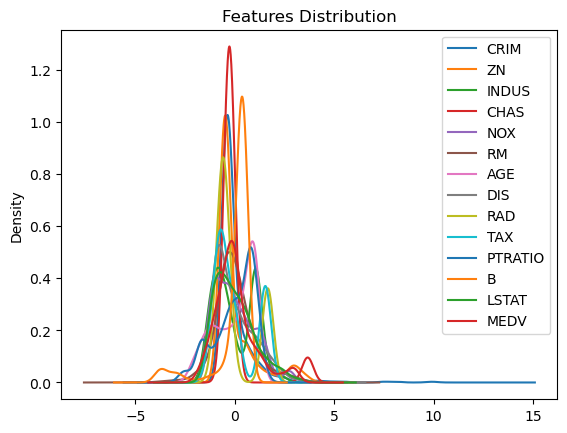

In [8]:
# plot the distribution for all 4 columns
plt.title("Features Distribution")
df_plot['CRIM'].plot(kind='kde')
df_plot['ZN'].plot(kind='kde')
df_plot['INDUS'].plot(kind='kde')
df_plot['CHAS'].plot(kind='kde')
df_plot['NOX'].plot(kind='kde')
df_plot['RM'].plot(kind='kde')
df_plot['AGE'].plot(kind='kde')
df_plot['DIS'].plot(kind='kde')
df_plot['RAD'].plot(kind='kde')
df_plot['TAX'].plot(kind='kde')
df_plot['PTRATIO'].plot(kind='kde')
df_plot['B'].plot(kind='kde')
df_plot['LSTAT'].plot(kind='kde')
df_plot['MEDV'].plot(kind='kde')

plt.legend()
plt.show()

**Note**: We can see that all 14 features "behaves" similar to the Gaussian Distribution with different mean and standard deviation. This plot add an additional confirmation as most of the dataset has Gaussian distribution. The data points near the mean are more frequent in occurrent that the data far from the mean.

*[Reference](https://www.investopedia.com/terms/n/normaldistribution.asp#:~:text=Normal%20distribution%2C%20also%20known%20as,as%20a%20%22bell%20curve%22.).*

# 3. Data Processing
**Note**: There are ways to process raw data that suitable for types of data and how they are structure such as check NaN, feature engineering, normalization, data imputation,... However, for this dataset, I will do the following steps: 
- Check NaN.
- Normalize the dataset.
- Split it into training and testing set.

## 3.1. Check For Not-a-Number (NaN) Data

In [9]:
# examine and replace missing values 
print(df.isnull().values.any())

False


## 3.2. Normalize & Split Dataset
**Note**: Split the data in to input features (X) and output label (y).

In [10]:
# get input features X 
X = df[list(df.columns[0:-1])]
print(X.shape)

(506, 13)


In [11]:
# get output feature y
y = df['MEDV']
print(y.shape)

(506,)


In [12]:
# partition into training/test/validation 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [13]:
# check shape
print(f"X_shape has shape: {X_train.shape}")
print(f"X_test has shape: {X_test.shape}")
print(f"y_train has shape: {y_train.shape}")
print(f"y_test has shape: {y_test.shape}")

X_shape has shape: (354, 13)
X_test has shape: (152, 13)
y_train has shape: (354,)
y_test has shape: (152,)


In [14]:
# normalized training data
mean = X_train.mean(axis=0)
X_train -= mean
std = X_train.std(axis=0)
X_train /= std

# normalized testing data
X_test -= mean
X_test /= std

**Note**: that we normalize the test data based on the training data. We don't want to normalized the test data based on the training distribution as we want to test the model on the same distribution of what we train. By doing this, we will avoid the "information leak" issue where the model might happen to learn something from the validation set, which will make the validation result less reliable.

# 4. Modeling
**Note**: As the dataset is a fairly small dataset, we only need a small model. We can use a larger model, however, it will be a waste of computing power and risk to the large model to learn unwanted patterns. In addition, if the model is too large, it will start to overfit right away which makes the validation loss curve looks choppy (due high-variance). If we limit the model's size, it will optimize less neuron and provide better quality

In [15]:
class SimpleNetwork(keras.Model):
    
    def __init__(self):
        """Constructor"""
        super().__init__()
        
        # define sub layers
        self.hidden_layer_1 = layers.Dense(64, activation="relu")
        self.hidden_layer_2 = layers.Dense(64, activation="relu")
        self.output_layer = layers.Dense(1)
        
    def call(self, inputs):
        """Forward pass
        @Parameters
        inputs (tensor): process input housing features.
        
        @Return
        outputs (tensor): output prediction of house price.
        """
        features = self.hidden_layer_1(inputs)
        features = self.hidden_layer_2(features)
        outputs = self.output_layer(features)
        
        return outputs

# 5. K-Fold Validation
**Note**: Right now, we don't know how well is our model's structure as well as the number of epochs to train (if we train the model too much, then the model will overfit!). For the larger dataset, we can simply take a portion of the traininig dataset as validation dataset and check the performance prior to training the entire training data. However, since the dataset is small, K-Fold validation will be a better choice. The image below showed how K-Fold validation works.

![](https://scikit-learn.org/stable/_images/grid_search_cross_validation.png)

[Reference](https://scikit-learn.org/stable/modules/cross_validation.html).

In [16]:
num_epochs = 500
k = 4
num_val_samples = len(X_train) // k
all_mae_histories = []

for i in range(k):
    print(f"Processing fold #{i}")
    
    # split 1 fold for validation
    val_data = X_train[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = y_train[i * num_val_samples: (i + 1) * num_val_samples]
    
    # get the rest of 3 folds for training
    partial_train_data = np.concatenate(
        [X_train[:i * num_val_samples],
        X_train[(i + 1) * num_val_samples:]],
        axis=0
    )
    partial_train_targets = np.concatenate(
        [y_train[:i * num_val_samples],
        y_train[(i + 1) * num_val_samples:]],
        axis=0
    )
        
    # build model
    model = SimpleNetwork()
            
    # initialize optimizer, loss function, and performance metrics
    model.compile(optimizer="rmsprop",
                  loss="mse",          # mse is a to-go loss function for regression
                  metrics=["mae"])
    
    # train model on training dataset
    history = model.fit(partial_train_data, 
                        partial_train_targets,
                        epochs=num_epochs, 
                        batch_size=16,
                        validation_data=(val_data, val_targets),
                        verbose=0) # verbose == training without print out every training epoch
    
    # log model performance
    mae_history = history.history["val_mae"]
    all_mae_histories.append(mae_history)

Processing fold #0


2023-02-18 05:18:33.902409: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64::/opt/conda/lib
2023-02-18 05:18:33.902480: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)


Processing fold #1
Processing fold #2
Processing fold #3


In [17]:
# basically, the matrix store 500 epochs (times) that re run K-fold and for each epoch we have 4 mae from a k-fold of that epoch.
print(np.array(all_mae_histories).shape)

(4, 500)


In [18]:
average_mae_history = []

# go thru 500 epochs
for i in range(num_epochs):
    temp = []
    
    # go thru each fold and get the mae at that epoch
    for x in all_mae_histories:
        temp.append(x[i])
    
    # calculate the mean mae for that epoch
    temp = np.mean(temp)
    
    # store in the average mae log
    average_mae_history.append(temp)

In [19]:
# check shape
print(len(average_mae_history))

500


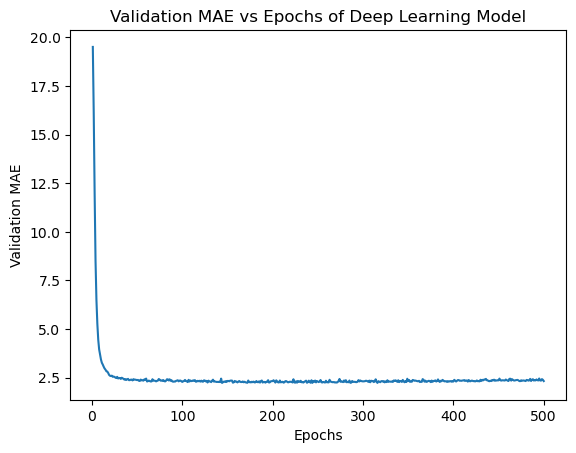

In [20]:
# plot validation score from history
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.title("Validation MAE vs Epochs of Deep Learning Model")
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()

**Note**: the validation MAE for the first few epochs is dramatically higher than the values that follow. Let’s omit the first 10 data points, which are on a different scale than the rest of the curve.

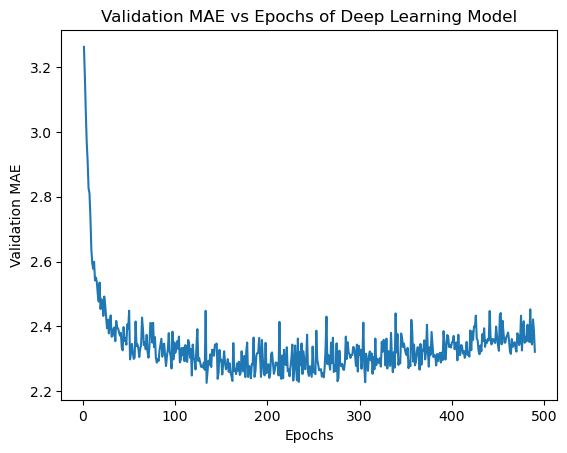

In [21]:
# plot the validation score, excluding the first 10 data points
truncated_mae_history = average_mae_history[10:]
plt.plot(range(1, len(truncated_mae_history) + 1), truncated_mae_history)
plt.title("Validation MAE vs Epochs of Deep Learning Model")
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()

**Note**: validation MAE stops improving significantly after 300-400 epochs (this number includes the 10 epochs we omitted). Past that point, we start overfitting.

# 6. Train Model on Full Training Dataset & Test on Testing Dataset

5/5 [==============================] - 0s 3ms/step - loss: 16.1799 - mean_absolute_error: 2.7190
Model: "simple_network_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            multiple                  896       
                                                                 
 dense_13 (Dense)            multiple                  4160      
                                                                 
 dense_14 (Dense)            multiple                  65        
                                                                 
Total params: 5,121
Trainable params: 5,121
Non-trainable params: 0
_________________________________________________________________


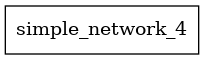

In [22]:
# construct model
model = SimpleNetwork()

# build model
model.compile(optimizer="rmsprop",
              loss=["mean_squared_error"],
              metrics=["mean_absolute_error"]) 

# train final model from what we learn: aka epochs=350
model.fit(X_train, y_train, epochs=350, batch_size=16, verbose=0)

# evaluate the model on the test dataset
test_mse_score, test_mae_score = model.evaluate(X_test, y_test)

# show the model summary
model.summary()
    
# plot the model architecture
keras.utils.plot_model(model, "my_model.png", show_shapes=True)

In [23]:
print(test_mae_score)

2.7189717292785645


In [24]:
print(f"The minimal house price is {min(y)}.")
print(f"The maximum house price is {max(y)}.")

The minimal house price is 5.0.
The maximum house price is 50.0.


**Note**: The MAE measure the difference between the predictions and the targets in regression. For this problem, if the MAE is 0.5, this means that the model prediction is off by `$500` on average. We see that the house price range is `$5000` to `$50,000`, thus, the fact that our model is off by `$2,543` in average is significant!

# 7. Model "Deployment" Test
**Note**: What if you want to see how our model perform during a "deployment" process? Let's test it on a sample on the testing dataset.

In [25]:
# predict on the entire test dataset
predictions = model.predict(X_test)

5/5 [==============================] - 0s 2ms/step


In [26]:
# get the prediction value
print(f"Model's prediction on the first house in the test dataset is: {predictions[0][0]}")

Model's prediction on the first house in the test dataset is: 22.243999481201172


In [27]:
# get all the labels and indices from test dataset
print(y_test)

329    22.6
371    50.0
219    23.0
403     8.3
78     21.2
       ... 
4      36.2
428    11.0
385     7.2
308    22.8
5      28.7
Name: MEDV, Length: 152, dtype: float64


**Note**: we see that the first house in the test dataset has index of 329. Here, the index is mixed up since we set random shuffle during the train/validate/test split in the data processing step.

In [28]:
print(df['MEDV'][329])

22.6


**Note**: We can see that the predicted price and the label do not offset by much (~`$1000`).

![](https://images.unsplash.com/photo-1506551907304-60bb62ffc9b0?ixlib=rb-4.0.3&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=1170&q=80)